In [1]:
import os
import numpy as np

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

np.set_printoptions(precision=4)
seg_length = 500

TensorFlow version: 2.11.0


In [2]:
X = None
y = None

db1_pos = ['chfdb']
db1_neg = ['nsrdb', 'fantasia']
db2_pos = ['chf2db']
db2_neg = ['nsr2db']

for db in db1_pos:
    for record in os.listdir(f'data/{db}/rr'):
        rr = np.loadtxt(f'data/{db}/rr/{record}')
        n_segments = rr.shape[0] // seg_length
        rr = rr[:n_segments*seg_length].reshape((n_segments, seg_length))
        labels = np.c_[np.ones(n_segments), np.zeros(n_segments)]

        if X is None or y is None:
            X = rr
            y = labels
        else:
            X = np.r_[rr, X]
            y = np.r_[labels, y]

for db in db1_neg:
    for record in os.listdir(f'data/{db}/rr'):
        rr = np.loadtxt(f'data/{db}/rr/{record}')
        n_segments = rr.shape[0] // seg_length
        rr = rr[:n_segments*seg_length].reshape((n_segments, seg_length))
        labels = np.c_[np.zeros(n_segments), np.ones(n_segments)]

        if X is None or y is None:
            X = rr
            y = labels
        else:
            X = np.r_[rr, X]
            y = np.r_[labels, y]

X.shape, y.shape

((7397, 500), (7397, 2))

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X = preprocessing.scale(X, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=410)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=410)

X_train.shape, X_valid.shape, X_test.shape

((5991, 500), (666, 500), (740, 500))

In [5]:
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from sklearn.metrics import f1_score, accuracy_score

def get_model():
    nclass = 2
    inp = tf.keras.layers.Input(shape=(500, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = tf.optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['acc'])
    model.summary()
    return model

model = get_model()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500, 1)]          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 496, 16)           96        
                                                                 
 conv1d_9 (Conv1D)           (None, 492, 16)           1296      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 246, 16)          0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 246, 16)           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 244, 32)           1568      
                                                           

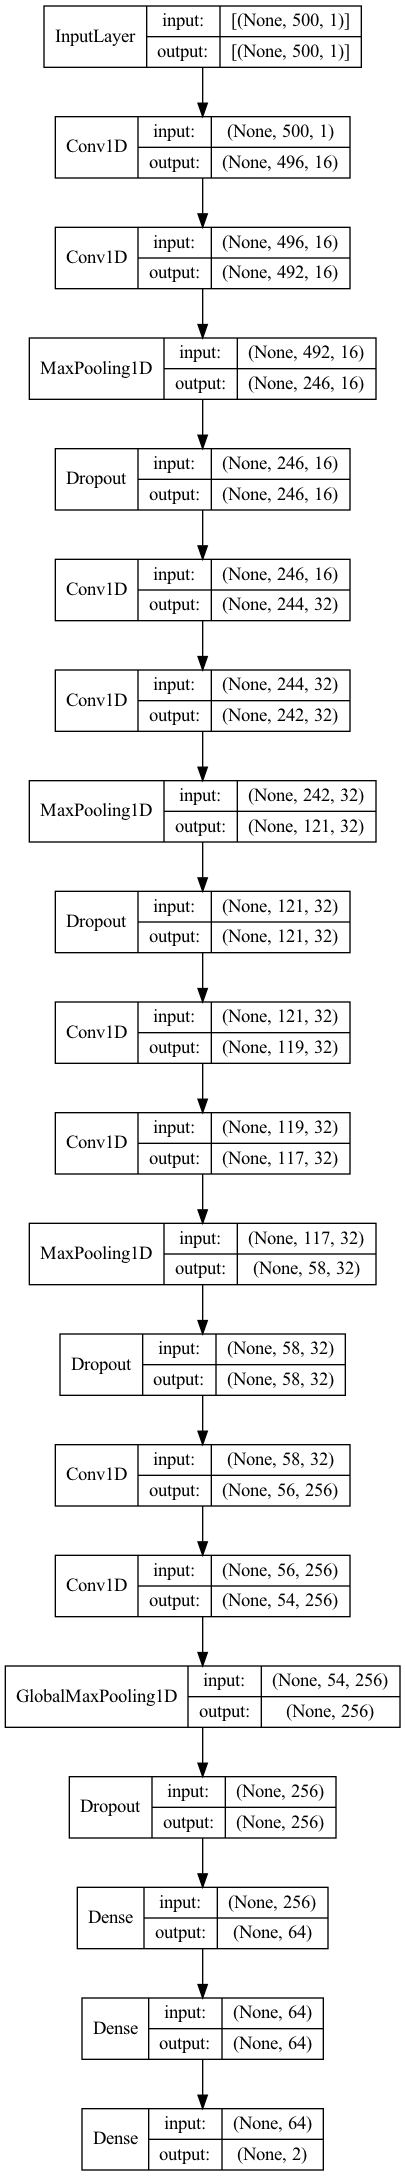

In [12]:
tf.keras.utils.plot_model(
    model,
    to_file='cnn-model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [ ]:
file_path = "baseline_cnn.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

model.fit(x=X_train, y=y_train, validation_data=(X_valid, y_valid),
          batch_size=128, epochs=100, callbacks=callbacks_list)

model.load_weights(file_path)

In [5]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

cnn_model = model

pred_test_cnn = cnn_model.predict(X_test)
pred_test_cnn = np.argmax(pred_test_cnn, axis=1)

print(recall_score(y_test.argmax(axis=1), pred_test_cnn ))
print(precision_score(y_test.argmax(axis=1), pred_test_cnn ))
print(accuracy_score(y_test.argmax(axis=1), pred_test_cnn ))

0.9695550351288056
0.92
0.9337837837837838


In [6]:
cnn_model.save('cnn_model.keras')